In [14]:
from typing import Type

In [15]:
from transformers import AutoTokenizer, AutoModel, AutoConfig, TrainingArguments, Trainer
import torch.nn as nn
from torch.optim import AdamW
from torch import Tensor
from datasets import load_from_disk
import matplotlib.pyplot as plt

In [16]:
CHECKPOINT = "google-bert/bert-large-cased-whole-word-masking-finetuned-squad"
# Model card: https://huggingface.co/google-bert/bert-large-cased-whole-word-masking-finetuned-squad

In [17]:
class CorrectnessModuleLLM(nn.Module):
    def __init__(self: Type["CorrectnessModuleLLM"],
                 checkpoint: str) -> None:
        super(CorrectnessModuleLLM, self).__init()
        self.embedding_body = AutoModel.from_pretrained(checkpoint, 
                                                        config=AutoConfig.from_pretrained(checkpoint,
                                                                                          output_attention=True,
                                                                                          output_hidden_states=True))
        self.logit_transform = nn.Linear(in_features = 1024, # This should be somehow dynamic. Can be with the help of above model's config variable
                                         out_features = 1,
                                         bias=True)
        self.output_transform = nn.Sigmoid()
        return
    
    def forward(self: Type["CorrectnessModuleLLM"],
                input_ids: Tensor,
                attention_mask) -> Tensor:
        llm_embeddings = self.embedding_body(input_ids=input_ids,
                                             attention_mask=attention_mask)
        cls_token_output = llm_embeddings.hidden_states[0]
        logits = self.logit_transform(cls_token_output)
        output_prob = self.output_transform(logits)
        return output_prob

In [18]:
## Tokenizer code
checkpoint_model_tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, return_tensors='pt')

def tokenize_and_align_dataset(sample):
    question_string = sample['question']
    answer_string = sample["answer"]
    final_input_string = f"{question_string} [SEP] {answer_string}"
    tokenized_inputs = checkpoint_model_tokenizer(final_input_string, add_special_tokens=True)
    return tokenized_inputs


In [ ]:
# Importing dataset
visa_qa_dataset = load_from_disk("../Datasets/Visa_QA_V3")
visa_qa_dataset

DatasetDict({
    train: Dataset({
        features: ['meta_tags', 'question', 'answer', 'target_score'],
        num_rows: 15789
    })
    test: Dataset({
        features: ['meta_tags', 'question', 'answer', 'target_score'],
        num_rows: 5264
    })
})

In [20]:
preprocessed_visa_qa = visa_qa_dataset.map(tokenize_and_align_dataset, batched=False)
preprocessed_visa_qa

Map:   0%|          | 0/15789 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Map: 100%|██████████| 5264/5264 [00:11<00:00, 468.04 examples/s]


DatasetDict({
    train: Dataset({
        features: ['meta_tags', 'question', 'answer', 'target_score', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15789
    })
    test: Dataset({
        features: ['meta_tags', 'question', 'answer', 'target_score', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5264
    })
})

In [ ]:
all_string_lens = []
all_token_lens = []
def get_lens(sample):
    total_string_len = len(sample['question'].split()) + len(sample['answer'].split())
    all_string_lens.append(total_string_len)
    all_token_lens.append(len(sample['input_ids']))
    return sample

preprocessed_visa_qa['train'].map(get_lens)


Map:  27%|██▋       | 4307/15789 [00:03<00:09, 1156.35 examples/s]

3830


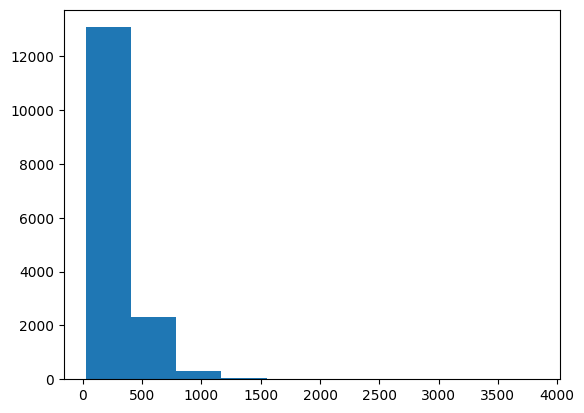

In [ ]:
plt.hist(all_string_lens)
print(max(all_string_lens))
plt.show()

372


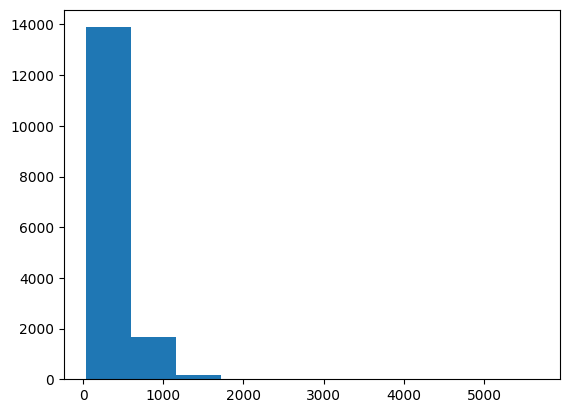

In [ ]:
plt.hist(all_token_lens)
print(len([x for x in all_token_lens if x > 1024]))
plt.show()

Since only 372 will be dropped, we will be dropping rows whose input ID lens are greater than 1024

In [ ]:
filtered_preprocessed_visa_qa = preprocessed_visa_qa.filter(lambda x: len(x['input_ids']) <= 1024)
filtered_preprocessed_visa_qa

Filter: 100%|██████████| 5264/5264 [00:02<00:00, 1931.24 examples/s]


DatasetDict({
    train: Dataset({
        features: ['meta_tags', 'question', 'answer', 'target_score', 'input_ids', 'token_type_ids', 'attention_mask', 'score'],
        num_rows: 15417
    })
    test: Dataset({
        features: ['meta_tags', 'question', 'answer', 'target_score', 'input_ids', 'token_type_ids', 'attention_mask', 'score'],
        num_rows: 5151
    })
})

In [ ]:
optimizer = AdamW(POS_tagger.parameters(), lr=5e-5)

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)



progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))


for epoch in range(num_epochs):
    POS_tagger.train()
    for batch in train_dataloader:
        batch = {k: v for k, v in batch.items()}
        outputs = POS_tagger(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar_train.update(1)

    POS_tagger.eval()
    for batch in eval_dataloader:
        batch = {k: v for k, v in batch.items()}
        with torch.no_grad():
            outputs = POS_tagger(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        # print(predictions.shape, "batch:", batch['labels'].shape)
        labels = batch['labels']
        true_predictions = [
            [labels_encoder.int2str(p.item()) for (
                p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [labels_encoder.int2str(l.item()) for (
                p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        # for sentence_true_labels, sentence_true_predictions in zip(true_labels, true_predictions):
        metric.add_batch(predictions=true_predictions, references=true_labels)
        progress_bar_eval.update(1)
    print("===================== Epoch: ", epoch, " =====================")
    print(metric.compute())